# Detección de anomalías usando un autoencoder

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

## Cargando dataset

El siguiente dataset contiene lecturas de ECG (electrocardiogramas) de pacientes.  
Cada fila corresponde a una lectura de ECG completa de un solo paciente. cada lectura está compuesta de 140 puntos.  
Las columnas de la 0 - 139 contiene los datos de ECG para un paciente. Estos datos son flotantes.  
La columna 140 es una etiqueta que indica si la lectura es normal o anormal. Esta columna es una variable categorica con valores 0 ó 1.  
Este dataset se obtuvo de la página de kaggle: https://www.kaggle.com/datasets/devavratatripathy/ecg-dataset/data

In [26]:
df = pd.read_csv("ecg.csv", header=None)

In [27]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


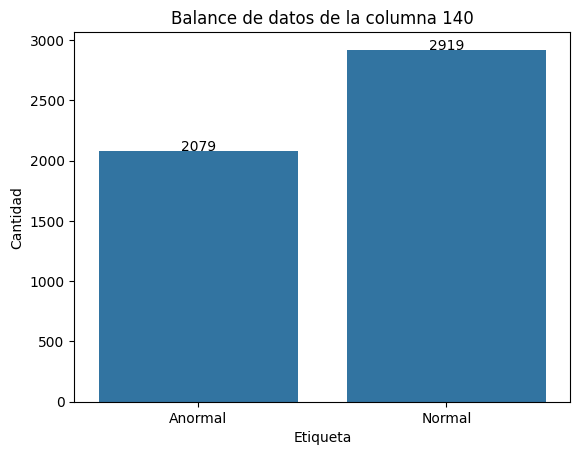

In [28]:
sns.countplot(x=df.iloc[:, -1])
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['Anormal', 'Normal'])
#Agregando la cantidad de datos a cada barra
for i in range(2):
    plt.text(i, df.iloc[:, -1].value_counts()[i], df.iloc[:, -1].value_counts()[i], ha = 'center')
plt.title('Balance de datos de la columna 140')
plt.show()

## Separando los datos de entrenamiento y prueba

In [29]:
etiquetas = df.iloc[:, -1] #Guardando las etiquetas
data = df.iloc[:, :-1] #Guardando los datos
# Normalizando los datos para que estén en el rango de 0 a 1
data = (data - data.min()) / (data.max() - data.min())

#Dividiendo los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, etiquetas, test_size=0.2, random_state=14)

In [30]:
normal_x_train = X_train[y_train == 1]
anormal_x_train = X_train[y_train == 0]
normal_x_test = X_test[y_test == 1]
anormal_x_test = X_test[y_test == 0]

## Creando autoencoder

In [32]:
latent_dim = 8
input_dim = X_train.shape[1]

#Creando el modelo
encoded_input = Input(shape=(input_dim,))
encoded = Dense(64, activation= 'relu')(encoded_input)
encoded = Dense(16, activation= 'relu')(encoded)
encoded = Dense(latent_dim, activation= 'relu')(encoded)
encoder = Model(encoded_input, encoded, name='encoder') #Creando el encoder

decoded_input = Input(shape=(latent_dim,))
decoded = Dense(16, activation= 'relu')(decoded_input)
decoded = Dense(64, activation= 'relu')(decoded)
decoded = Dense(input_dim, activation= 'sigmoid')(decoded)
decoder = Model(decoded_input, decoded, name='decoder') #Creando el decoder

autoencoder_input = Input(shape = (input_dim,))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name = "autoencoder")

autoencoder.compile(optimizer='adam', loss='mse')

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         9,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,200 (39.84 KB)

 Trainable params: 10,200 (39.84 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 140)            │         9,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,332 (40.36 KB)

 Trainable params: 10,332 (40.36 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8)              │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 140)            │        10,332 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,532 (80.20 KB)

 Trainable params: 20,532 (80.20 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

El autoencoder se entrena únicamente con valores normales, también los datos de validación son normales

In [33]:
# Entrenar el modelo
history = autoencoder.fit(normal_x_train, normal_x_train, 
                          epochs=40, 
                          batch_size=32,
                          validation_data=(normal_x_test, normal_x_test),
                          shuffle=True) 

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0044
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_lo

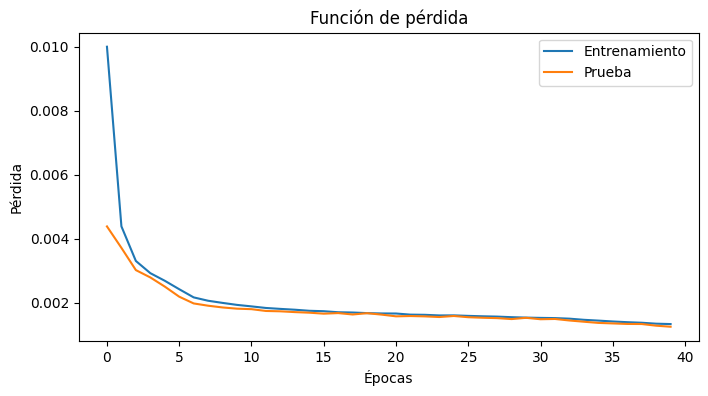

In [34]:
plt.figure(figsize= (8, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Función de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## Visualizando reconstrucción

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


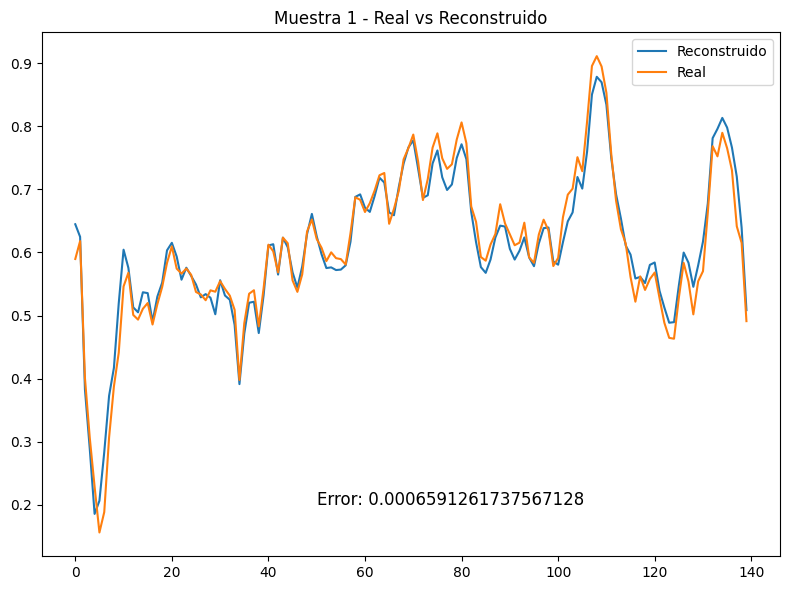

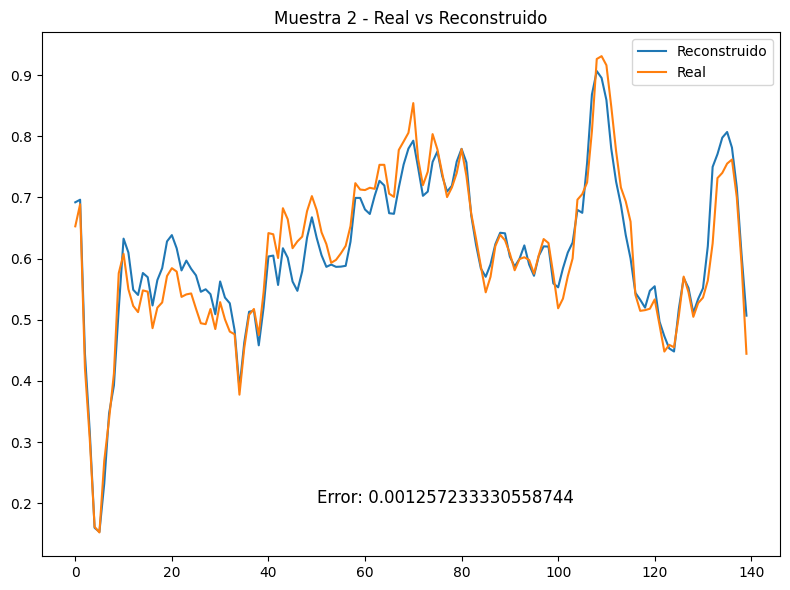

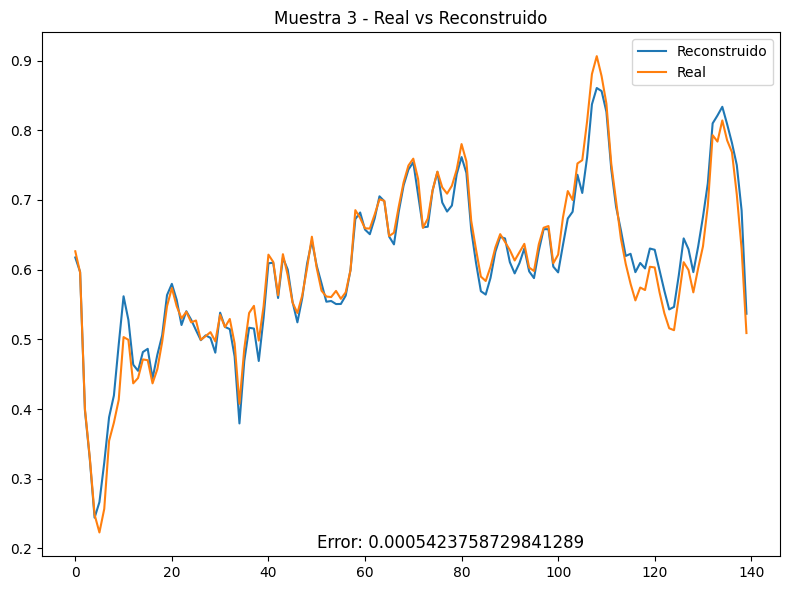

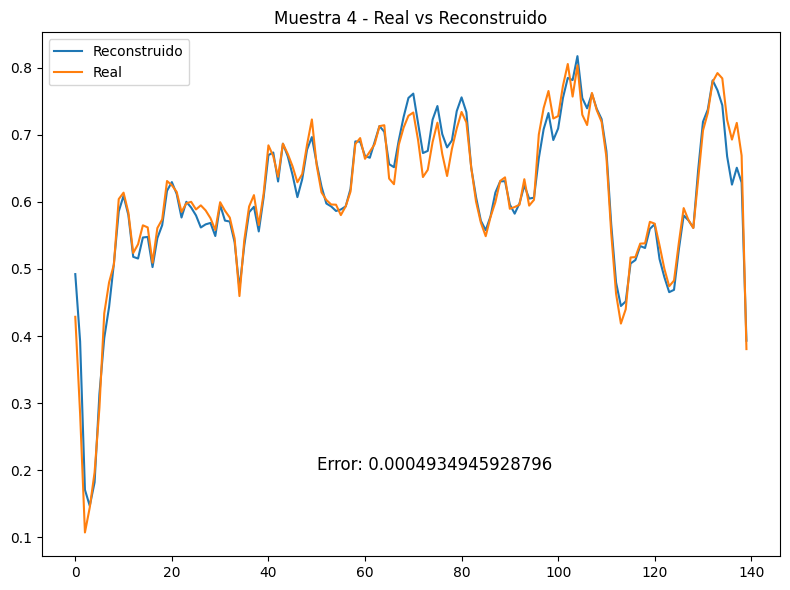

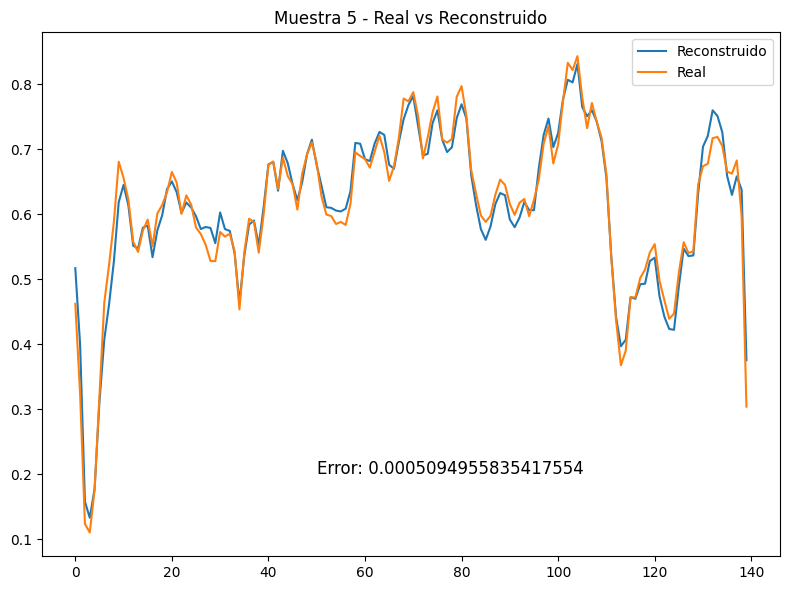

In [44]:
# Obtener las reconstrucciones del autoencoder para los datos de prueba
reconstructed_imgs = autoencoder.predict(normal_x_test)

# Crear las gráficas
num_samples = 5

for i in range(num_samples):
    plt.figure(figsize=(8, 6))
    plt.title(f'Muestra {i+1} - Real vs Reconstruido')
    plt.plot(reconstructed_imgs[i], label='Reconstruido')
    plt.plot(normal_x_test.iloc[i], label='Real')
    plt.legend()
    plt.tight_layout()
    error = np.mean((reconstructed_imgs[i] - normal_x_test.iloc[i])**2)
    plt.text(50, 0.2, f'Error: {error}', fontsize=12)
    plt.show()

## Testeando con datos anormales
Ahora se construye un dato anormal con el autoencoder

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


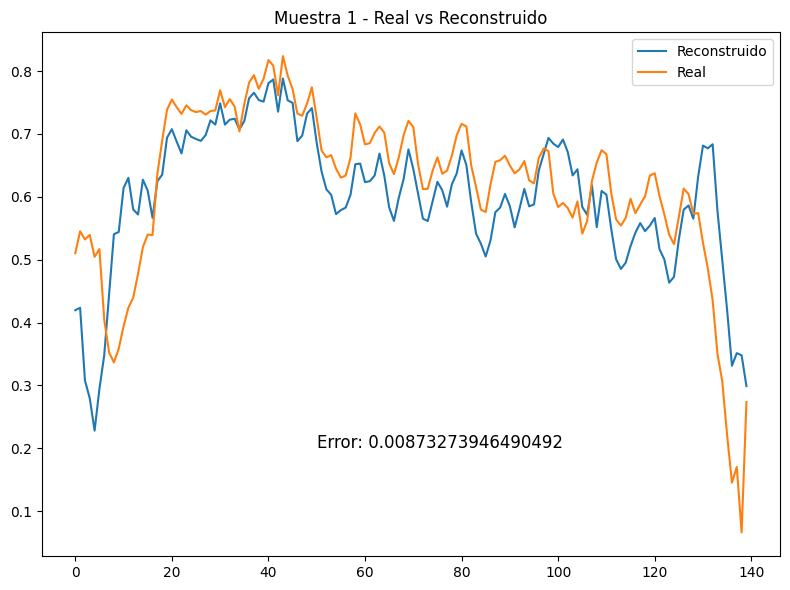

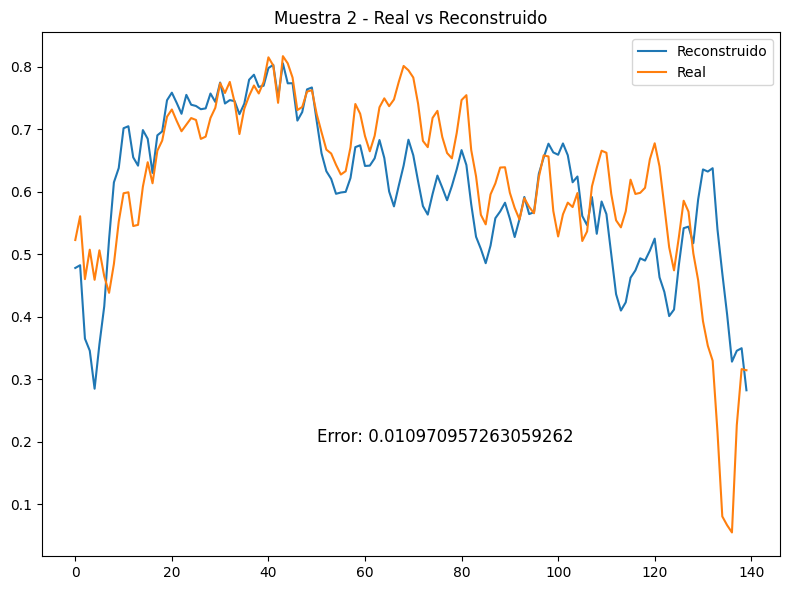

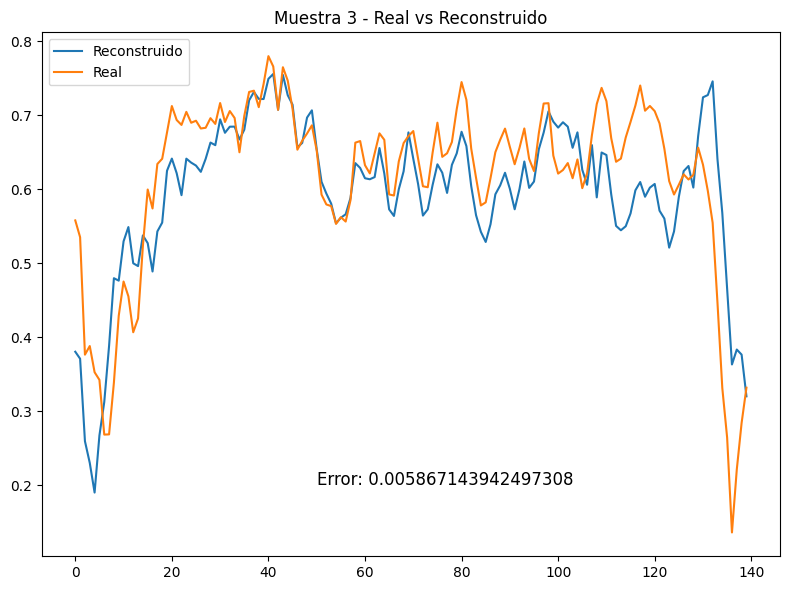

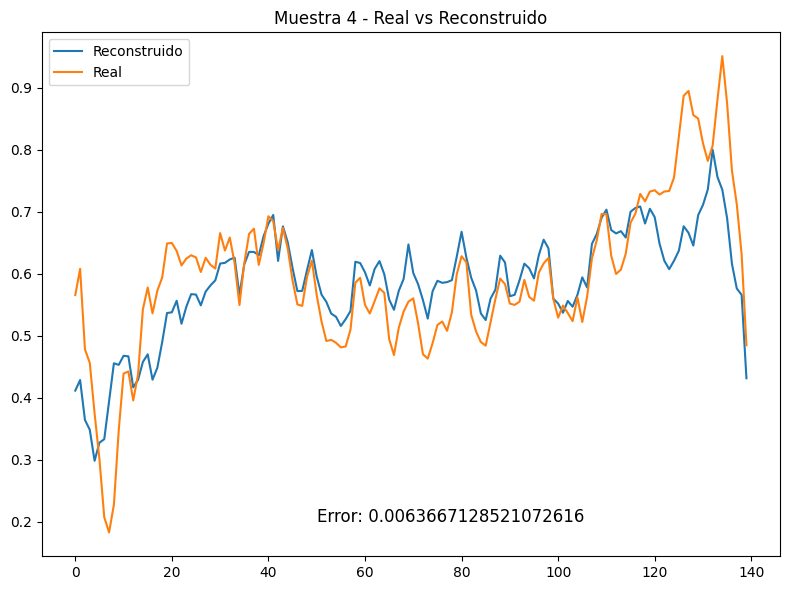

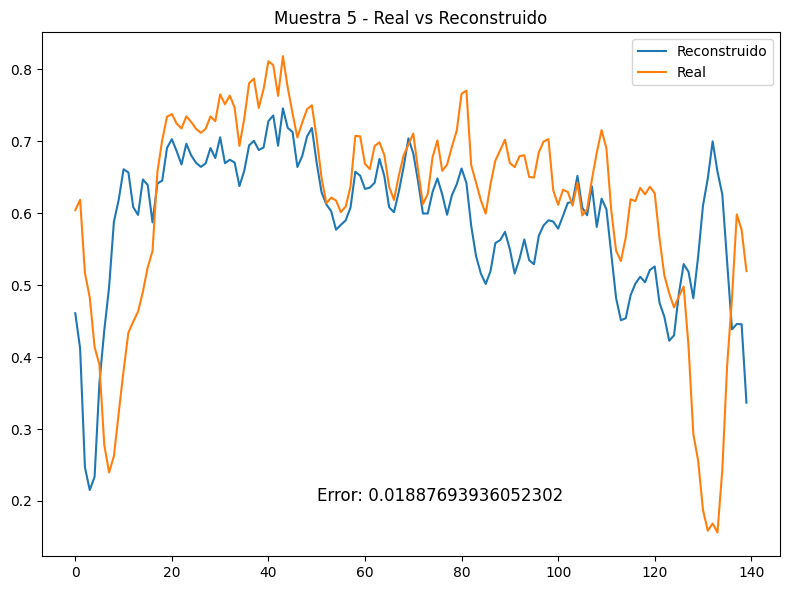

In [43]:
# test con datos anormales
reconstructed_imgs_anormal = autoencoder.predict(anormal_x_test)

# Crear las gráficas
num_samples = 5

for i in range(num_samples):
    plt.figure(figsize=(8, 6))
    plt.title(f'Muestra {i+1} - Real vs Reconstruido')
    plt.plot(reconstructed_imgs_anormal[i], label='Reconstruido')
    plt.plot(anormal_x_test.iloc[i], label='Real')
    plt.legend()
    plt.tight_layout()
    error = np.mean(np.square(anormal_x_test.iloc[i] - reconstructed_imgs_anormal[i]))
    plt.text(50, 0.2, f'Error: {error}', fontsize=12)
    plt.show()


## Etiquetar datos anómalos

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


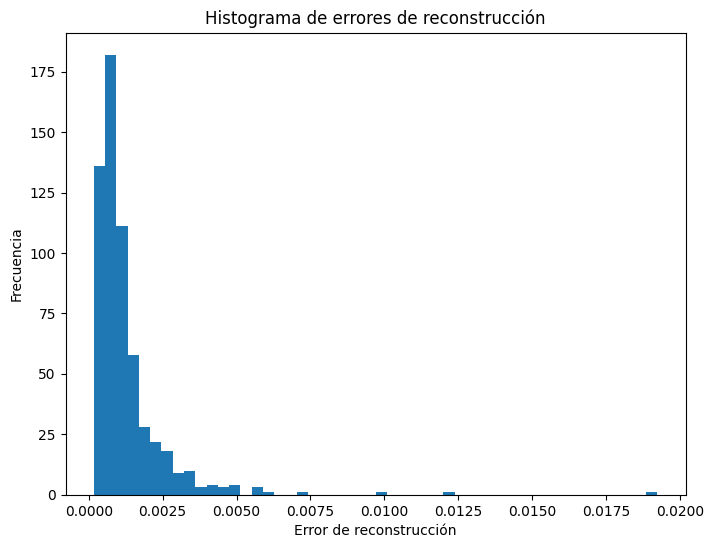

In [47]:
reconstructed_normal_test = autoencoder.predict(normal_x_test)  # Reconstrucción de los datos normales
mse_normal_test = np.mean(np.square(normal_x_test - reconstructed_normal_test), axis=1)  # MSE para cada muestra

# Crear un histograma de los errores de reconstrucción
plt.figure(figsize=(8, 6))
plt.hist(mse_normal_test, bins=50)
plt.title('Histograma de errores de reconstrucción')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Frecuencia')
plt.show()

In [48]:
# Establecer el threshold usando el MSE de los datos normales
threshold = np.mean(mse_normal_test) + 2 * np.std(mse_normal_test)

print("Threshold establecido:", threshold)

Threshold establecido: 0.003934333714169826


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


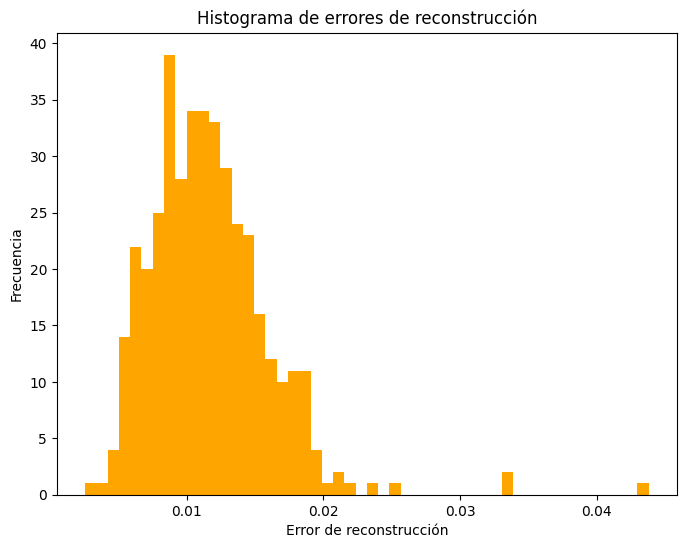

In [53]:
# Para los datos anómalos
reconstructed_anomalous = autoencoder.predict(anormal_x_test)
mse_anomalous = np.mean(np.square(anormal_x_test - reconstructed_anomalous), axis=1)

# Crear un histograma de los errores de reconstrucción
plt.figure(figsize=(8, 6))
plt.hist(mse_anomalous, bins=50, color='orange')
plt.title('Histograma de errores de reconstrucción')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Frecuencia')
plt.show()


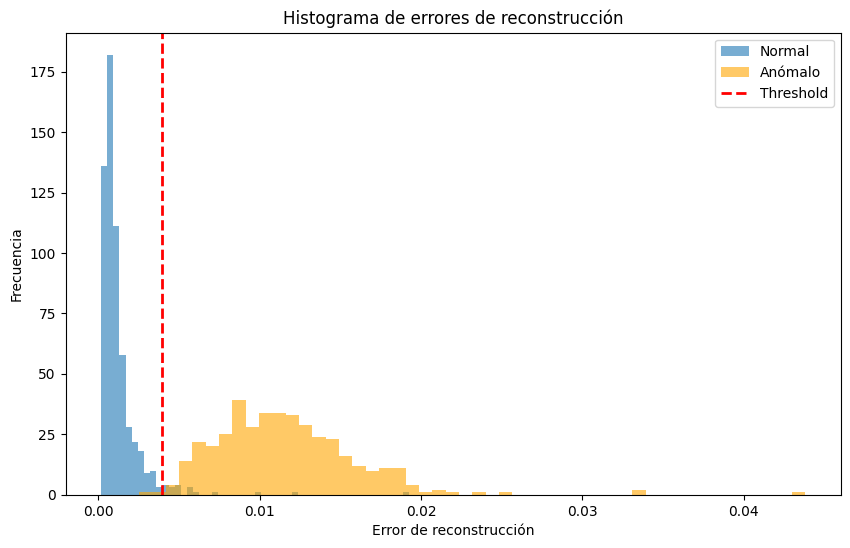

In [54]:
# Crear un histograma de los errores de reconstrucción para datos normales y anómalos
plt.figure(figsize=(10, 6))
plt.hist(mse_normal_test, bins=50, alpha=0.6, label='Normal')
plt.hist(mse_anomalous, bins=50, alpha=0.6, label='Anómalo', color='orange')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Histograma de errores de reconstrucción')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [57]:
def etiquetar_y_predecir(autoencoder, X_test, y_test, threshold):
    # Obtener las reconstrucciones del autoencoder para los datos de prueba
    reconstructed_test = autoencoder.predict(X_test)
    
    # Calcular el error de reconstrucción (MSE) para cada muestra
    mse_test = np.mean(np.square(X_test - reconstructed_test), axis=1)
    
    # Etiquetar los datos según el umbral
    predicciones = mse_test < threshold # 1 es normal, 0 es anormal
    
    # Comparar las etiquetas predichas con las etiquetas reales
    etiquetas_reales = y_test == 1 # 1 es normal, 0 es anormal
    precision = np.mean(predicciones == etiquetas_reales)
    
    return predicciones, precision

# Usar la función con los datos de prueba
predicciones, precision = etiquetar_y_predecir(autoencoder, X_test, y_test, threshold)
print("Precisión de la predicción:", precision)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Precisión de la predicción: 0.979


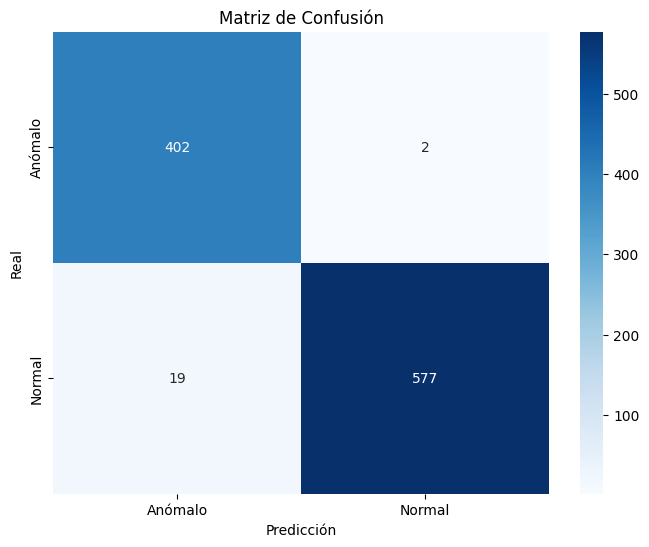

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Crear la matriz de confusión
cm = confusion_matrix(y_test, predicciones)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anómalo', 'Normal'], yticklabels=['Anómalo', 'Normal'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()